In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### Training dataset

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[0:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [4]:
block_size = 3
X = []
Y = []

for w in words[:5]:
    print(w)
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[ix] for ix in context), '--->', itos[ix])
        context = context[1:] + [ix]
        
X = torch.tensor(X)
Y = torch.tensor(Y)

print(X)
print(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .
tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],


In [5]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

X has 32 training examples with 3 values for each input 

### Embedding

For each character, initialize a feature vector of 2 dim with random values. The values gets learnt while training.

How is it different from a regular neural network?
- For bigram, the input vector size is 27 with one hot encoding. <br>
Eg: e -> m <br>
<b>Input</b>: [0,0,0,0, 1(e) ,0,0,...] : 27<br>
<b>Output</b>: [0,0,0,... 1(m), ...] : 27 <br>
- For trigram, the input would be 27^3  <br>
Eg: emm -> a <br>
<b>Input</b>: [0,0,0,.. 1(emm), ...] :27^3 <br>
<b>Output</b>: [0, 1(a), 0...] : 27 <br>
<br>
<b>Embedding</b> <br>
Input size is 27*2 = 54 <br>
Embedding matrix can also be thought as weight matrix with embedding layer as linear layer without any activation functions like tanh

In [6]:
C = torch.randn((27,2))

In [7]:
C[5]

tensor([-0.1935, -0.7877])

In [8]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.1935, -0.7877])

In [9]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [10]:
torch.cat([emb[:, 0 , :], emb[:, 1 , :], emb[:, 2 , :]], 1).shape

torch.Size([32, 6])

In [11]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

In [12]:
emb = C[X].view((-1,6)) # use -1 to automatically detect the row size

In [13]:
emb

tensor([[ 1.0810, -1.7611,  1.0810, -1.7611,  1.0810, -1.7611],
        [ 1.0810, -1.7611,  1.0810, -1.7611, -0.1935, -0.7877],
        [ 1.0810, -1.7611, -0.1935, -0.7877, -0.7436,  2.0911],
        [-0.1935, -0.7877, -0.7436,  2.0911, -0.7436,  2.0911],
        [-0.7436,  2.0911, -0.7436,  2.0911, -0.9397,  0.5381],
        [ 1.0810, -1.7611,  1.0810, -1.7611,  1.0810, -1.7611],
        [ 1.0810, -1.7611,  1.0810, -1.7611,  0.2390, -1.3165],
        [ 1.0810, -1.7611,  0.2390, -1.3165,  0.5444, -1.0121],
        [ 0.2390, -1.3165,  0.5444, -1.0121,  0.1545, -1.2684],
        [ 0.5444, -1.0121,  0.1545, -1.2684, -0.3751, -0.3193],
        [ 0.1545, -1.2684, -0.3751, -0.3193,  0.1545, -1.2684],
        [-0.3751, -0.3193,  0.1545, -1.2684, -0.9397,  0.5381],
        [ 1.0810, -1.7611,  1.0810, -1.7611,  1.0810, -1.7611],
        [ 1.0810, -1.7611,  1.0810, -1.7611, -0.9397,  0.5381],
        [ 1.0810, -1.7611, -0.9397,  0.5381, -0.3751, -0.3193],
        [-0.9397,  0.5381, -0.3751, -0.3

### Hidden layers 

In [14]:
W1 = torch.randn(6, 100)
b1 = torch.randn(100)
h = torch.tanh(emb @ W1 + b1)

In [15]:
h.shape

torch.Size([32, 100])

In [16]:
W2 = torch.randn(100, 27)
b2 = torch.randn(27)
logits = h @ W2 + b2

In [17]:
logits.shape

torch.Size([32, 27])

### Loss 

In [18]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
prob.shape

torch.Size([32, 27])

In [19]:
prob[torch.arange(32), Y] # gives probability assigned by the model to the correct output character

tensor([1.2444e-07, 1.2861e-10, 1.3019e-11, 3.3311e-10, 4.7810e-11, 2.9297e-04,
        2.2457e-12, 4.5779e-16, 5.0818e-16, 8.5540e-17, 5.9568e-09, 6.0811e-02,
        2.7933e-13, 1.3469e-15, 2.6738e-09, 2.7024e-03, 2.2405e-17, 2.9377e-11,
        1.4409e-10, 5.9378e-12, 2.5217e-09, 1.3050e-03, 1.6391e-10, 1.1353e-14,
        5.6198e-03, 2.3090e-11, 8.1586e-02, 2.8048e-05, 6.6285e-14, 2.2137e-11,
        6.6934e-07, 3.5986e-02])

In [20]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(20.9255)

In [21]:
loss = F.cross_entropy(logits, Y)
loss

Reasons for using cross_entropy instead of calculating manually:
- Efficient calculation by simplifying the expression
- Numerically stable, extreme values do not effect the result much

In [22]:
logits = torch.tensor([-100, -3, 0, 100]) - 100 # using an offset so that the numbers are not too big
counts = logits.exp()
counts

tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])

In [23]:
probs = counts / counts.sum()
probs

tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])

### Summary

Full dataset

In [27]:
block_size = 3
X = []
Y = []

for w in words:
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
        
X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

Initialize parameters

In [64]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn(6, 100, generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn(100, 27, generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters)


3481

Training

In [71]:
for _ in range(10000):
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]].view(-1,6)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix]) #more efficient because of optimizations
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.01 * p.grad

# loss on entire training set
emb = C[X].view(-1,6)
h = torch.tanh(emb @ W1 + b1)
logits = h @ W2 + b2
loss_full = F.cross_entropy(logits, Y)
print(loss_full.item())

2.3151400089263916


### Finding a good learning rate 

In [58]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [62]:
lri = []
lossi = []
for i in range(1000):
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]].view(-1,6)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix]) #more efficient because of optimizations
    print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    lri.append(lre[i]) # using exponent for tracking
    lossi.append(loss.item())

# loss on entire set
emb = C[X].view(-1,6)
h = torch.tanh(emb @ W1 + b1)
logits = h @ W2 + b2
loss_full = F.cross_entropy(logits, Y)
print(loss_full.item())

7.644352436065674
8.48176097869873
8.984582901000977
6.858883380889893
11.525235176086426
6.936550140380859
10.307232856750488
8.732192993164062
8.073792457580566
6.802507400512695
8.038005828857422
9.89240837097168
8.99244213104248
11.304093360900879
7.101819038391113
7.277734756469727
5.9824371337890625
10.076783180236816
7.350369453430176
6.005909442901611
10.274280548095703
6.357754707336426
9.442078590393066
9.153715133666992
9.392545700073242
8.080985069274902
9.460317611694336
8.011083602905273
5.83234977722168
8.005804061889648
7.5256028175354
8.353302955627441
7.714493274688721
6.753020286560059
6.849246978759766
6.568879127502441
8.783463478088379
7.867014408111572
8.344801902770996
9.299100875854492
8.496932029724121
8.416952133178711
7.9986395835876465
8.198491096496582
10.043275833129883
6.190323352813721
8.077071189880371
7.14039945602417
8.20827579498291
6.8668742179870605
6.883121967315674
7.733640193939209
6.19541072845459
7.527784824371338
8.164051055908203
8.54963779

3.013878107070923
2.709118127822876
2.599048376083374
2.6769702434539795
3.271775960922241
2.685986280441284
2.5455851554870605
2.451451539993286
2.3711934089660645
2.363006591796875
2.828165292739868
3.1855597496032715
2.985560178756714
2.9265546798706055
3.4039502143859863
2.8522753715515137
2.5688624382019043
3.2758371829986572
3.072489023208618
2.677388906478882
3.2489962577819824
2.8383562564849854
2.470869302749634
3.120640754699707
2.9348318576812744
2.6015243530273438
2.6857404708862305
3.030489921569824
2.573686361312866
2.624502420425415
2.908328056335449
3.432215929031372
3.2811989784240723
2.6097307205200195
2.6225907802581787
2.7985825538635254
2.99692964553833
2.523998260498047
3.1616008281707764
2.728292942047119
2.708017349243164
3.2789952754974365
3.371626138687134
2.928110361099243
2.8221538066864014
2.4382097721099854
3.183215856552124
2.6484134197235107
2.7655742168426514
2.4597373008728027
3.210294723510742
2.4372148513793945
3.0030901432037354
2.889204740524292
3.

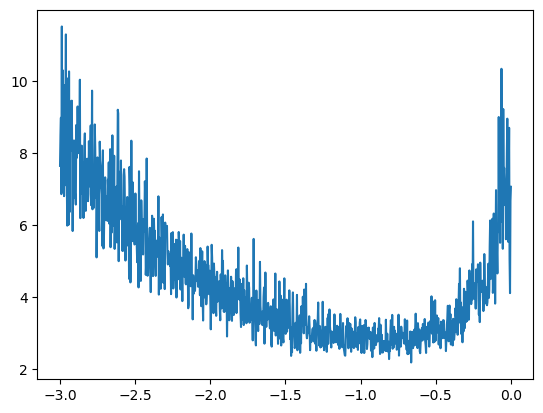

In [63]:
plt.plot(lri, lossi)

We can use exponent -1 for learning rate as loss is less for x=-1

### Splitting the data to tune hyperparameters

In [72]:
def build_dataset(words):
    block_size = 3
    X = []
    Y = []

    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtst, Ytst = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [131]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,5), generator=g)
W1 = torch.randn(15, 200, generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn(200, 27, generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters)

8762

In [132]:
lri = []
lossi = []
stepi = []

In [133]:
for i in range(200000):
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]].view(-1,15)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix]) #more efficient because of optimizations
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

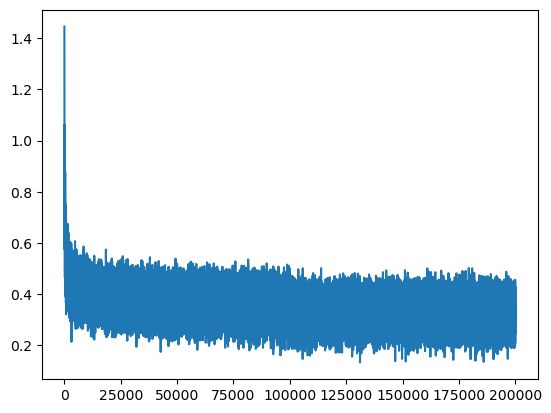

In [134]:
plt.plot(stepi, lossi)

In [135]:
# loss on training set
emb = C[Xtr].view(-1,15)
h = torch.tanh(emb @ W1 + b1)
logits = h @ W2 + b2
loss_full = F.cross_entropy(logits, Ytr)
print(loss_full.item())

2.1661767959594727


In [136]:
# loss on dev set
emb = C[Xdev].view(-1,15)
h = torch.tanh(emb @ W1 + b1)
logits = h @ W2 + b2
loss_full = F.cross_entropy(logits, Ydev)
print(loss_full.item())

2.1870365142822266


##### Visualize embedding vectors

In [108]:
C

tensor([[ 2.2831e-01, -3.4732e-01],
        [-2.9051e-01, -3.1533e-01],
        [ 2.8821e-01,  4.2577e-02],
        [ 1.1197e-01,  1.3702e-01],
        [ 3.9079e-01,  1.9561e-01],
        [-6.8445e-01, -2.3240e-01],
        [ 3.6971e-01,  1.1809e-01],
        [ 8.2290e-01,  3.1168e+00],
        [ 5.1734e-01,  1.4774e-01],
        [-6.9190e-01,  2.1609e-01],
        [ 3.7900e-01,  3.2294e-01],
        [ 2.6186e-01,  1.3027e-01],
        [ 3.8083e-01,  6.5335e-01],
        [ 6.0818e-01,  3.0863e-01],
        [-3.0166e-01,  6.3250e-01],
        [-3.8103e-01, -8.9109e-02],
        [ 2.0672e-01,  1.1173e-01],
        [ 1.1277e+00,  1.8513e+00],
        [ 5.5053e-02,  4.5873e-01],
        [-4.1616e-04,  2.3263e-01],
        [ 6.7952e-02,  1.9314e-01],
        [-3.7897e-01,  9.4616e-02],
        [ 3.9922e-01,  3.3873e-01],
        [ 3.6498e-01,  2.4215e-01],
        [-5.8825e-02,  4.3550e-01],
        [-9.0743e-01,  5.2064e-01],
        [ 2.8692e-01,  2.3029e-01]], requires_grad=True)

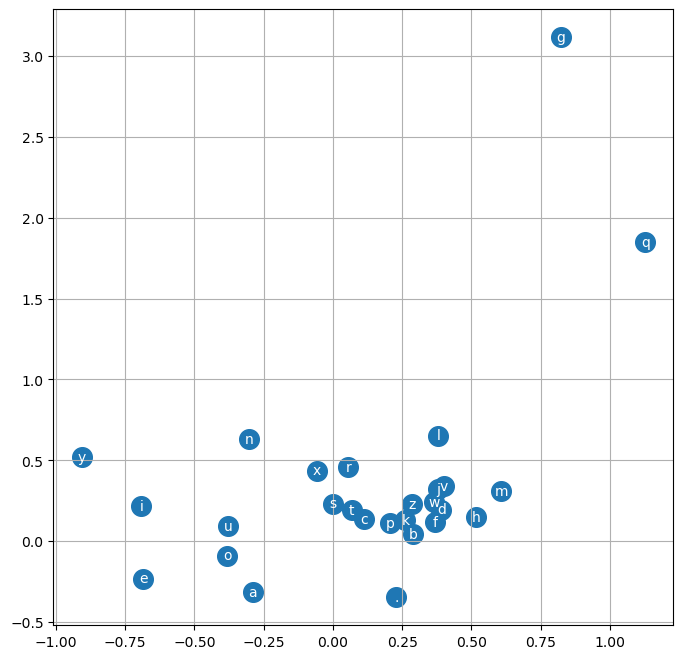

In [107]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
    
plt.grid('minor')

## Sampling from the model

In [141]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix==0:
            break
    print(''.join(itos[i] for i in out))

yodellah.
kamino.
sis.
quilte.
jamylora.
adurba.
alan.
laya.
hahartha.
kaskayla.
kessiara.
kiison.
chail.
crynch.
geana.
kaida.
kyrick.
shan.
lishith.
olyn.
